# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [132]:
# Show df to get an idea of the data
df

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45989,142.0,neural networks for beginners: popular types a...,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45990,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452
45991,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [134]:
# Show df_content to get an idea of the data
df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049


In [135]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

`1.1` What is the distribution of how many articles a user interacts with in the dataset?

In [136]:
# Start by getting the count of how many times each user has interacted with each article
df_user_interactions=df.groupby(['email', 'article_id']).size().reset_index().rename(columns={0:'n_interactions'})

In [137]:
df_articles_per_user=df_user_interactions.groupby('email')['article_id'
                                                        ].count(
                                                        ).reset_index(
                                                        ).rename(columns={'article_id':
                                                                          'article_count'}
                                                                          )

In [138]:
df_articles_per_user.sort_values(by='article_count')

,email,article_count
5105,fdcc9a10d385a872222eff525a106fd34066b213,1
5063,fb3ee06c168690746bfa6739c39bff0215119a1e,1
1831,58533f2f526885e6a526049add77d1c33887ae0c,1
5067,fb878b2b9f1fcb18bac2918316ede5486c0f195a,1
79,042dd3f6128f1b83a921288e525bce62ebeade5d,1
...,...,...
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,97
4032,c60bb0a50c324dad0bffd8809d121246baef372b,100
4401,d9032ff68d0fd45dfd18c0c5f7324619bb55362c,101
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,135


In [139]:
# Get the median number of interactions with an article by any 1 user: 
df_articles_per_user['article_count'].median()

np.float64(3.0)

`1.2` Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [140]:
df_total_user_interactions=df_user_interactions.groupby('email'
                                                        )['n_interactions'].sum(
                                                        ).reset_index(
                                                        ).sort_values(by='n_interactions', 
                                                                    ascending=False
                                                                    )

In [141]:
# Count how many times an interaction has been the 1st interaction, 2nd interaction, etc
df_interaction_count=df_total_user_interactions.groupby('n_interactions').size().reset_index().rename(columns={0:'n_interactions_count'})

# Get share of interactions
df_interaction_count['n_interactions_share']=df_interaction_count['n_interactions_count']/df_interaction_count['n_interactions_count'].sum()

In [142]:
# Get the mean number of interactions with an article by any 1 user: 
df_interaction_count['n_interactions'].mean()

np.float64(68.08771929824562)

In [143]:
# Get the max number of interactions with an article by any 1 user: 
df_interaction_count['n_interactions'].max()

np.int64(364)

In [144]:
df_interaction_count['n_interactions'].describe()

count    114.000000
mean      68.087719
std       58.234582
min        1.000000
25%       29.250000
50%       57.500000
75%       90.500000
max      364.000000
Name: n_interactions, dtype: float64

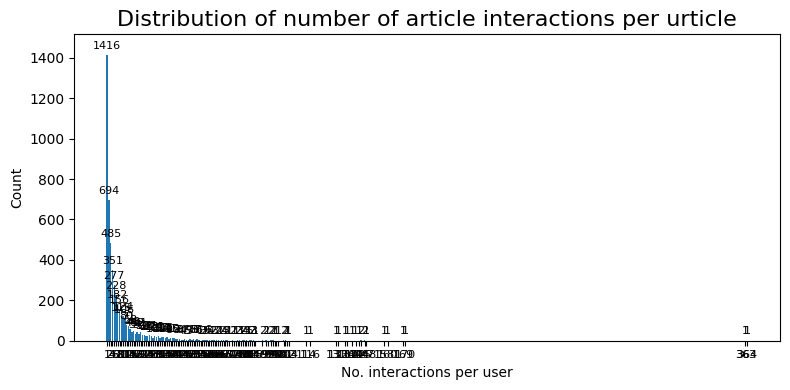

In [145]:
def vizualise_interactions(df):
    # Plotting the bar chart
    plt.figure(figsize=(8, 4))

    plt.bar(df['n_interactions'], df['n_interactions_count'])

    # Adding labels and title
    plt.title('Distribution of number of article interactions per urticle', fontsize=16)
    plt.ylabel('Count', fontsize=10)
    plt.xlabel('No. interactions per user', fontsize=10)

    # Adding x-tick labels
    plt.xticks(df['n_interactions'], fontsize=8)
    plt.yticks(fontsize=10)

    # Adding value labels on top of the bars
    for i, val in enumerate(df['n_interactions_count']):
        plt.text(df['n_interactions'][i], val + 20, str(val), ha='center', va='bottom', fontsize=8)

    plt.ylim(0, max(df['n_interactions_count'])+100)

    # Showing the plot
    plt.tight_layout()
    plt.show()

vizualise_interactions(df_interaction_count)

In [146]:
# Set a cutoff no of interactions for a summary category - to deal with outliers

def summarize_occurences(df, cutoff):

    ## Filter rows where n_interactions >= x
    above_x=df.query(f'n_interactions>={cutoff}')

    ## Summarize number of occurances of a user interacting more than 10 times with
    ## an article 
    above_x_summary = {
        'n_interactions': f'x>{cutoff}',
        'n_interactions_count': above_x['n_interactions_count'].sum(),
        'n_interactions_share': above_x['n_interactions_share'].sum()
    }

    ## Filter rows where n_interactions < x
    below_x = df.query(f'n_interactions<{cutoff}')

    ## Combine data for below cutoff with the summary row for those above cutoff interactions
    df_condensed = pd.concat([below_x, pd.DataFrame([above_x_summary])], ignore_index=True)

    # Change data type for label variable n_interactions
    df_condensed['n_interactions']=df_condensed['n_interactions'].astype('str')

    return df_condensed

In [147]:
df_interaction_occurence_condensed=summarize_occurences(df_interaction_count, 20)

In [148]:
df_interaction_occurence_condensed

,n_interactions,n_interactions_count,n_interactions_share
0,1,1416,0.275058
1,2,694,0.134810
2,3,485,0.094211
3,4,351,0.068182
4,5,277,0.053807
5,6,228,0.044289
6,7,182,0.035354
7,8,156,0.030303
8,9,115,0.022339
9,10,124,0.024087


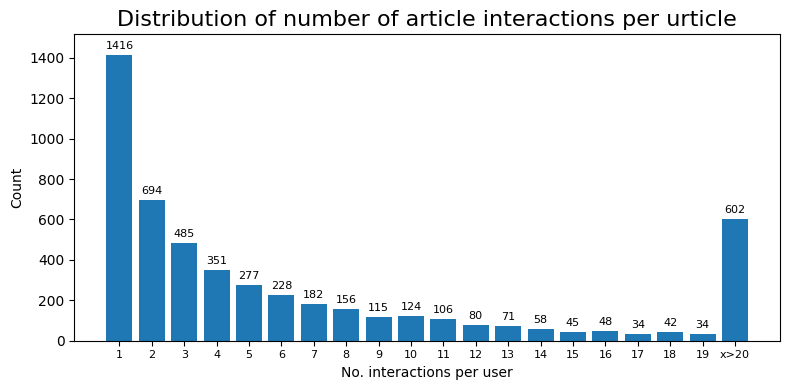

In [149]:
vizualise_interactions(df_interaction_occurence_condensed)

In [150]:
# Fill in the median and maximum number of user_article interactios below

# Get median value
median_val=df_articles_per_user['article_count'].median()
print(f'50% of individuals interact with {median_val} number of articles or fewer.')

# Get user interactions by 1 single article
max_views_of_article_by_user = df_user_interactions['n_interactions'].max()
print(f'The maximum number of user-article interaction of 1 article by any 1 user is {max_views_of_article_by_user}.')

# Get overall user interactions
df_total_user_interactions=df_user_interactions.groupby('email'
                                                        )['n_interactions'].sum(
                                                        ).reset_index(
                                                        ).sort_values(by='n_interactions', 
                                                                    ascending=False
                                                                    )
max_views_by_user=df_total_user_interactions.iloc[0]['n_interactions']
print(f'The maximum number of user-article interaction by any 1 user is {max_views_by_user}.')


50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interaction of 1 article by any 1 user is 42.
The maximum number of user-article interaction by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [151]:
# Find and explore duplicate articles
df_content=df_content.sort_values(by='article_id')
duplicate_ids=df_content[df_content.duplicated(subset='article_id')]['article_id']

In [152]:
duplicate_articles=df_content[df_content['article_id'].isin(duplicate_ids)]
duplicate_articles

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


Comment: although the article IDs are the same, not all of the articles are the same. - In a thourough approach each article should be compared and re-ided rather than drop all duplicate ids.

In [153]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [154]:
unique_articles=df['article_id'].nunique()
print(f'The number of unique articles that have at least one interaction are {unique_articles}')

The number of unique articles that have at least one interaction are 714


In [155]:
total_articles=df_content['article_id'].nunique()
print(f'The number of unique articles on the IBM platform are {total_articles}')

The number of unique articles on the IBM platform are 1051


In [156]:
unique_users=df['email'].nunique()
print(f'The number of unique users are {unique_users}')

The number of unique users are 5148


In [157]:
user_article_interactions = df.shape[0]

print(f'The number of user-article interactions is {user_article_interactions}')


The number of user-article interactions is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [158]:
df_article_view_count=df.groupby('article_id').size(
                                ).reset_index().rename(columns={0:'view_count'}
                                ).sort_values(by='view_count', ascending=False)

df_article_view_count

,article_id,view_count
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627
...,...,...
458,1072.0,1
581,1266.0,1
277,653.0,1
289,675.0,1


In [159]:
# The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id=df_article_view_count.iloc[0]['article_id'].astype('str')
print(f'The id of the most viewed is: {most_viewed_article_id})')

# The most viewed article in the dataset was viewed how many times?
max_views=df_article_view_count.iloc[0]['view_count'].astype('int')
print(f'The most viewed article, {most_viewed_article_id}, was viewed {max_views} times)')

The id of the most viewed is: 1429.0)
The most viewed article, 1429.0, was viewed 937 times)


In [160]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [161]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [162]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Count number of interactions per article
    df_article_count=df.groupby(['title','article_id']).size(
                                ).reset_index().rename(columns={0:'view_count'}
                                )
    
    # Sort articles descending by number of interactions
    df_article_count=df_article_count.sort_values(by='view_count', 
                                                ascending=False)

    # Select top n articles and return article titles:s
    top_articles=df_article_count.iloc[:n]['title']
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
        # Count number of interactions per article
    df_article_count=df.groupby(['title','article_id']).size(
                                ).reset_index().rename(columns={0:'view_count'}
                                )
    
    # Sort articles descending by number of interactions
    df_article_count=df_article_count.sort_values(by='view_count', 
                                                ascending=False)

    # Select top n articles and return article titles:s
    top_article_ids=df_article_count.iloc[:n]['article_id']
    
    return top_article_ids # Return the top article titles from df (not df_content)

In [163]:
print(get_top_articles(10))
print(get_top_article_ids(10))

637           use deep learning for image classification
396          insights from new york car accident reports
668                       visualize car data with brunel
650    use xgboost, scikit-learn & ibm watson machine...
485    predicting churn with the spss random tree alg...
356         healthcare python streaming application demo
323    finding optimal locations of new store using d...
151             apache spark lab, part 1: basic concepts
133              analyze energy consumption in buildings
345    gosales transactions for logistic regression m...
Name: title, dtype: object
637    1429.0
396    1330.0
668    1431.0
650    1427.0
485    1364.0
356    1314.0
323    1293.0
151    1170.0
133    1162.0
345    1304.0
Name: article_id, dtype: float64


In [164]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [165]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create a df with the count of how many interactions each user had with each article
    df_user_article_count=df.groupby(['user_id','article_id']).size(
                            ).reset_index().assign(interaction=1).drop(columns=0)
    
    # Pivot the df using user id as row, article as column and interaction as value
    user_item=df_user_article_count.pivot(index='user_id', 
                                         columns='article_id', 
                                        values='interaction')
    
    # Fill missing values with 0, i.e. user has interacted with the article 0 times
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [166]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [167]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_similarities = user_item.dot(np.transpose(user_item))

    # sort by similarity
    sorted_similar_users =user_similarities[user_id].reset_index().sort_values(by=user_id, ascending=False)

    # create list of just the ids and remove the own user's id
    most_similar_users=sorted_similar_users[sorted_similar_users['user_id']!=user_id]['user_id'].tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [168]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 131, 3870, 4201, 46, 395]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [169]:
article_list=[0, 1430.0, 1314.0, 1429.0]

articles=df.drop_duplicates(subset='article_id')

article_names=articles[articles['article_id'].isin(article_list)]['title'].tolist()

In [170]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_similarities = user_item.dot(np.transpose(user_item))

    # sort by similarity
    sorted_similar_users =user_similarities[user_id].reset_index().sort_values(by=user_id, ascending=False)

    # create list of just the ids and remove the own user's id
    most_similar_users=sorted_similar_users[sorted_similar_users['user_id']!=user_id]['user_id'].tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar


def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Ensure article_ids are treated as string variables
    df['article_id']=df['article_id'].astype('str')

    # Get a df of the unique articles in df
    articles=df.drop_duplicates(subset='article_id')

    # Filter on the list of article ids provided and return a list of the article titles
    article_names=articles[articles['article_id'].isin(article_ids)]['title'].tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Melt user item matrix into a list of user_id:s, article_id:s and interactions.
    user_item_long=user_item.reset_index(
                        ).melt( id_vars='user_id',
                            var_name='article_id',
                            value_name='interaction'
                        ).sort_values(by='user_id')
    
    # Ensure article_ids are treated as string variables
    user_item_long['article_id']=user_item_long['article_id'].astype('str')

    # Filter on interactions being larger than 0, i.e. the articles a user has read
    user_item_long=user_item_long[user_item_long['interaction']>0]

    # Filter on user id
    article_ids=user_item_long[user_item_long['user_id']==user_id]['article_id'].tolist()

    # Get article names using the function get_article_names
    article_names=get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get the articles seen by the user so that these can be removed later
    user_articles_read, _ = get_user_articles(user_id)
    
    # Find similar users
    similar_users = find_similar_users(user_id)
    
    # Keep the recommended movies here
    recs = np.array([])
    
    # Loop through similar users to find articles they have seen that the target user has not
    for user in similar_users:

        # Get the articles seen by the similar user
        similar_user_articles, _ = get_user_articles(user)
        
        # Find articles the target user hasn't seen
        new_recs = np.setdiff1d(similar_user_articles, user_articles_read, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) >= m:
            break
        
    # Make sure we only have the m no of recomendations
    recs=recs[:m]
    
    return recs # return your recommendations for this user_id   

In [171]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [172]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
    '''

    # compute similarity of each user to the provided user
    user_similarities = user_item.dot(np.transpose(user_item))

    # sort by similarity
    sorted_similar_users=user_similarities[user_id].reset_index().sort_values(by=user_id, ascending=False)

    # Get the total interactions per user and sort by total interactions (descending)
    total_user_interactions = df.groupby('user_id')['article_id'].count()

    # Rename column counting number of interactions
    total_user_interactions=total_user_interactions.reset_index().rename(columns={'article_id':
                                                                                'total_interactions'})

    # Merge total interactions with the sorted similar users based on user_id
    total_similar_user_interactions = sorted_similar_users.merge(total_user_interactions, on='user_id')

    # Remove the user to ensure it does not recommend itself
    total_similar_user_interactions=total_similar_user_interactions[total_similar_user_interactions['user_id']!=user_id]

    # Sort first by total interactions
    neighbors_df = total_similar_user_interactions.sort_values(by=[user_id, 'total_interactions'], ascending=[False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions.
    '''
    # Get the articles seen by the user so that these can be removed later
    user_articles_read, _ = get_user_articles(user_id)
    
    # Find top sorted users
    similar_users = get_top_sorted_users(user_id)

    # Get list of similar user id:s
    similar_users=similar_users['user_id'].to_list()
    
    # Keep the recommended movies here
    recs = np.array([])
    
    # Loop through similar users to find articles they have seen that the target user has not
    for user in similar_users:

        # Get the articles seen by the similar user
        similar_user_articles, _ = get_user_articles(user)
        
        # Find articles the target user hasn't seen
        new_recs = np.setdiff1d(similar_user_articles, user_articles_read, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) >= m:
            break
    
    # Convert to strings before sorting
    recs = recs.astype(str)

    # Grouping articles by interaction count
    article_interactions = df.groupby('article_id').count()['user_id'].reset_index()

    # Use recs by similar users to sort article interactions
    sorted_recs=article_interactions[article_interactions['article_id'].isin(recs)].sort_values('user_id', ascending=False)

    # Return new list of articles recomended by similar users and sorted by interaction
    recs_sorted=sorted_recs['article_id'].tolist()

    # Get the m first recommendations
    recs=recs_sorted[:m]

    # Get article names using the function get_article_names
    rec_names=get_article_names(recs)

    return recs, rec_names # return your recommendations for this user_id

In [173]:
rec_ids, rec_names = user_user_recs_part2(20, 20)

In [174]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


In [175]:
check_answer=['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

set(check_answer) == set(rec_ids)

True

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [176]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0]['user_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['user_id'] # Find the 10th most similar user to user 131

In [177]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Where we to have a completelly new user we would use the get_top_articles() function above to make recommendations. The logic being that since we don't know anything about the preferences of the new user, the best option would be the most popular articles among all other users.

One way of making another recomendation would be to look at articles that users are likelly to come back and read more than one time. I.e. articles that are so interesting that users come back and read more often. 

One way could be to extract both the number of interactions, as before, as well as a weight for the mean amount of multi-reads by users.**

In [178]:
def get_weighted_top_articles(m, df=df):
    # Sum up interactions for each article across all users
    article_interactions_per_user=df.groupby(['article_id', 'user_id']).size().reset_index().rename(columns={0: 'total_interactions'})

    # Get both total sum of interactions per article, but also mean amounts of same-user interactions per article
    article_interactions_per_user=article_interactions_per_user.groupby('article_id')['total_interactions'].agg(['sum', 'mean']).reset_index()

    # Use mean amounts of same-user visits per article as a weight on the sum of interactions.
    article_interactions_per_user['weighted_total_interactions']=article_interactions_per_user['sum']*article_interactions_per_user['mean']

    # Only keep article_id and weighted sum of interactions
    article_interactions_per_user=article_interactions_per_user[['article_id','weighted_total_interactions']]

    # Ensure article_ids are treated as string variables
    article_interactions_per_user['article_id']=article_interactions_per_user['article_id'].astype('str')

    # Sort by total interactions in descending order
    df_top_weighted_articles = article_interactions_per_user.sort_values(by='weighted_total_interactions', ascending=False)

    # Extract list using only article id:s
    top_weighted_articles=df_top_weighted_articles['article_id'].tolist()[:m]

    return top_weighted_articles

In [179]:
# Check which top articles are genereted with 
top_weighted_articles=get_weighted_top_articles(10)
top_articles=get_top_article_ids(10).tolist()

In [180]:
top_articles

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [181]:
top_weighted_articles

['1429.0',
 '1330.0',
 '1293.0',
 '1431.0',
 '1427.0',
 '1170.0',
 '1314.0',
 '1162.0',
 '1364.0',
 '1393.0']

In [182]:
# Find overlap
overlap = set(top_weighted_articles) & set(top_articles)
print(f'The articles that are recommended with both top lists are: {overlap}')

# Find items not in both lists
not_in_both = set(top_weighted_articles) ^ set(top_articles)
print(f'The articles that are highlighted by the weighted top list are: {not_in_both}')

The articles that are recommended with both top lists are: {'1162.0', '1170.0', '1293.0', '1431.0', '1427.0', '1429.0', '1330.0', '1364.0', '1314.0'}
The articles that are highlighted by the weighted top list are: {'1393.0', '1304.0'}


In [183]:
## Check the two articles
article_interactions_per_user=df.groupby(['article_id', 'user_id']).size().reset_index().rename(columns={0: 'total_interactions'})

## Get both total sum of interactions per article, but also mean amounts of same-user interactions per article
article_interactions_per_user=article_interactions_per_user.groupby('article_id')['total_interactions'].agg(['sum', 'mean']).reset_index()


In [184]:
# Tis way of looking at the user interactions would highlight that
article_interactions_per_user[article_interactions_per_user['article_id'].isin(not_in_both)]

,article_id,sum,mean
213,1304.0,483,1.712766
276,1393.0,455,2.087156


** Looking at the example above shows that a weighted recommendation would catch articles that are read several times, while maintaining the base of amount of interactions. **

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [185]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10).tolist()

In [186]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [187]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [188]:
# quick look at the matrix
user_item_matrix

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [189]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

** The big difference is that we have no missing values. In the lesson we used user ratings to predict what users think about movies. In this case we predict user interaction. Since we have manually defined our dataset as being 1 if there has been an interaction and 0 otherwise we have manually removed the problem med nan values**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

c:\Users\M56330\Documents\_repos\udacity\05_experimental_design\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


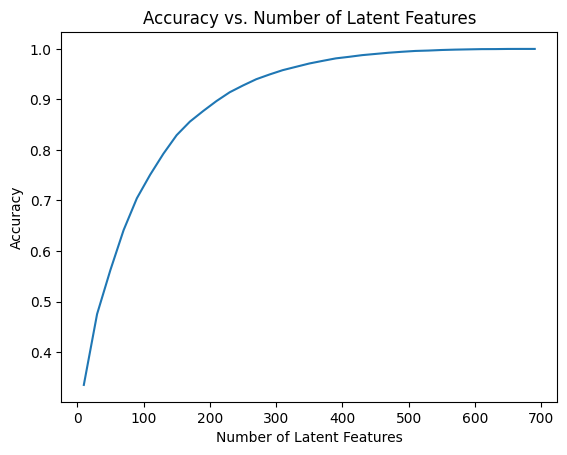

In [190]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [191]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [192]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                    (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create a user item for training data

    ## Create a df with the count of how many interactions each user had with each article
    df_train_count=df_train.groupby(['user_id','article_id']).size(
                            ).reset_index().assign(interaction=1).drop(columns=0)

    ## Pivot the df using user id as row, article as column and interaction as value
    user_item_train=df_train_count.pivot(index='user_id', 
                                        columns='article_id', 
                                        values='interaction')

    ## Fill missing values with 0, i.e. user has interacted with the article 0 times
    user_item_train.fillna(0, inplace=True)

    # Create a user item for test data

    ## Create a df with the count of how many interactions each user had with each article
    df_test_count=df_test.groupby(['user_id','article_id']).size(
                        ).reset_index().assign(interaction=1).drop(columns=0)

    ## Pivot the df using user id as row, article as column and interaction as value
    user_item_test=df_test_count.pivot(index='user_id', 
                                        columns='article_id', 
                                        values='interaction')

    ## Fill missing values with 0, i.e. user has interacted with the article 0 times
    user_item_test.fillna(0, inplace=True)

    # Get the ID of all test articles
    test_arts=user_item_test.columns.to_list()

    # Get the ID of all test users
    test_idx=user_item_test.index.to_list()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [193]:
# Count how many users are in both datasets
user_item_test[user_item_test.index.isin(user_item_train.index)].shape[0]

20

In [194]:
# Count how many users are in both datasets
user_item_test[~user_item_test.index.isin(user_item_train.index)].shape[0]

662

In [195]:
# Count how many columns in the test set that are also in the train-set
user_item_test.columns[user_item_test.columns.isin(user_item_train.columns)].shape[0]

574

In [196]:
# Count how many columns in the test set that are NOT in the train-set
user_item_test.columns[~user_item_test.columns.isin(user_item_train.columns)].shape[0]

0

In [197]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.

`5.1` Find predictable data

In [198]:
# Since we can only predict common users and articles that exist in both datasets
# we use this for the test.
overlapping_users = np.intersect1d(user_item_test.index, user_item_train.index)
overlapping_articels = np.intersect1d(user_item_test.columns, user_item_train.columns)

In [199]:
# Get positional indices for rows and columns
overlapping_users_pos = user_item_test.index.get_indexer(overlapping_users)
overlapping_articels_pos = user_item_test.columns.get_indexer(overlapping_articels)

In [200]:
num_latent_feats = np.arange(10,700+10,20)
results = []

# Perform SVD
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

for k in num_latent_feats:
    # Calculate training error

    
    # Truncate to k latent features
    u_new = u_train[:, :k]
    s_new = np.diag(s_train[:k])
    vt_new = vt_train[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est)
    
    # sum up errors 
    err_train = np.sum(np.sum(np.abs(diffs_train), axis=1))

    # Calculate accuracy for the training set
    accuracy_train=(1-np.array(err_train)/(user_item_train.shape[0]*user_item_train.shape[1]))

    # Calculate test error and accuracy

    ## Calculate difference from estimated user_item matrix from above and test_user_item_matrix
    test_est = pd.DataFrame(user_item_est, index=user_item_train.index, columns=user_item_train.columns)

    ## Overlapping users and articles
    diffs_test = np.subtract(user_item_test.loc[overlapping_users, overlapping_articels], 
                            test_est.loc[overlapping_users, overlapping_articels]
                            )

    ## Sum up test errors 
    err_test = np.sum(np.sum(np.abs(diffs_test), axis=1))

    ## Calculate accuracy for the testing set
    accuracy_test=(1-np.array(err_test)/(user_item_test.shape[0] * user_item_test.shape[1]))

    # Append results to list
    results.append({"num_latent_feats": k, 
                    "err_train": err_train, 
                    "accuracy_train": accuracy_train, 
                    "err_test": err_test,
                    "accuracy_test": accuracy_test}
                    )
    
df_results=pd.DataFrame(results)

In [201]:
df_results

,num_latent_feats,err_train,accuracy_train,err_test,accuracy_test
0,10,26542.0,0.991715,248.0,0.999366
1,30,20886.0,0.993481,269.0,0.999313
2,50,17312.0,0.994596,283.0,0.999277
3,70,14149.0,0.995584,303.0,0.999226
4,90,11642.0,0.996366,318.0,0.999188
5,110,9745.0,0.996958,339.0,0.999134
6,130,8068.0,0.997482,350.0,0.999106
7,150,6735.0,0.997898,359.0,0.999083
8,170,5678.0,0.998228,367.0,0.999063
9,190,4767.0,0.998512,375.0,0.999042


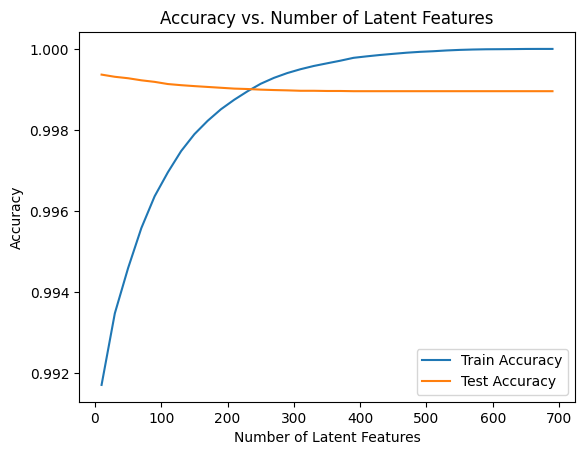

In [202]:
plt.plot(df_results['num_latent_feats'], df_results['accuracy_train'], label='Train Accuracy');
plt.plot(df_results['num_latent_feats'], df_results['accuracy_test'], label='Test Accuracy');

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

plt.legend();
plt.show;

`5.` Analyze answer using prediction and recall scores


In [203]:
test_subset = user_item_test.loc[overlapping_users, overlapping_articels]
train_subset = user_item_train.loc[overlapping_users, overlapping_articels]

In [204]:
def update_SVD_with_lat_features(train_subset, k):
    # Perform SVD
    u_train, s_train, vt_train = np.linalg.svd(train_subset)
    
    # Truncate to k latent features
    s_new = np.diag(s_train[:k])
    u_new = u_train[:, :k]
    vt_new = vt_train[:k, :]

    # Compute predictions
    pred_interaction = np.dot(np.dot(u_new, s_new), vt_new)

    # Apply threshold for binary predictions, 
    # 1 if the predicition is above 0.5, otherwise 1
    predictions = (pred_interaction >= 0.5).astype(int)

    return predictions

In [205]:
# Check for different k-values
k_list = [1,2,3,4,5,6,7,8,9, 10, 15, 20]
results = []

for k in k_list:
    # Collect precision for the k-level
    pred_interaction=update_SVD_with_lat_features(train_subset, k)

    # Calculate standard errors for the predictions
    sse = ((test_subset - pred_interaction)**2).to_numpy().sum()

    # Get precision and recall for the k-level
    precision = precision_score(test_subset.values.flatten(), pred_interaction.flatten())
    recall = recall_score(test_subset.values.flatten(), pred_interaction.flatten())

    # Calculate F1 score
    f1 = f1_score(test_subset.values.flatten(), pred_interaction.flatten())

    # Append results in a summary table
    results.append({"k": k, "SSE": sse, "Precision": precision, "Recall": recall, "F1 Score": f1})

# Convert results to a DataFrame
pd.DataFrame(results)

,k,SSE,Precision,Recall,F1 Score
0,1,242.0,0.184211,0.032110,0.054688
1,2,272.0,0.153846,0.055046,0.081081
2,3,289.0,0.126316,0.055046,0.076677
3,4,313.0,0.131783,0.077982,0.097983
4,5,329.0,0.122449,0.082569,0.098630
5,6,350.0,0.111765,0.087156,0.097938
6,7,363.0,0.103825,0.087156,0.094763
7,8,369.0,0.100529,0.087156,0.093366
8,9,380.0,0.099010,0.091743,0.095238
9,10,386.0,0.096154,0.091743,0.093897


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**The case we have here is a limitation of the SVD model. Since we only have 20 users that we can use, we quickly approach a situation where the number of latent features are as many as the number of users. That causes over-fitting and the model, thereby increasing the error as k increases. We can also see that both recall and precision is low for all of our available k-levels.

This means that using this dataset, the best awy to recomend articles we currently have is the recomender we built above, taking the nearest user and combining that with the most popular articles**

In [72]:
rec_ids, rec_names = user_user_recs_part2(20, 1)

print(f'This means that for user 20, our best recomendation is still {rec_names}')

This means that for user 20, our best recomendation is still ['use deep learning for image classification']


<a id='conclusions'></a>

## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [73]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1